<a href="https://colab.research.google.com/github/aayushhiiiiii/dietcheck/blob/main/01_task1_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DietCheck: Task 1 - Dietary Classification

**Course:** CS6120 Natural Language Processing  
**Project:** DietCheck - An NLP System for Dietary Claim Verification  
**Authors:** Aayushi Saraswat, Rahul Thirumurugan

---

## Overview

This notebook implements **Task 1: Dietary Classification** - a multi-label classification system that determines whether packaged foods meet specific dietary requirements.

### Classification Labels

Four binary labels based on FDA nutritional thresholds:

| Label | Threshold | Regulatory Basis |
|-------|-----------|------------------|
| **keto_compliant** | ≤40g net carbs/serving | Ketogenic diet standard |
| **high_protein** | ≥10g protein/serving | FDA 21 CFR §101.54(b) - 20% DV |
| **low_sodium** | ≤140mg sodium/serving | FDA 21 CFR §101.61(b)(4) |
| **low_fat** | ≤3g fat/serving | FDA 21 CFR §101.62(b)(2) |

### Models Implemented

This notebook progresses through increasingly sophisticated approaches:

1. **Rule-Based Baseline** - FDA threshold-based classification (interpretable, transparent)
2. **TF-IDF + Logistic Regression** - Traditional ML baseline with ingredient text features
3. **BERT Text-Only** - Fine-tuned BERT using only ingredient lists
4. **Multimodal BERT** - BERT text embeddings + numeric nutrition features (A- grade requirement)

### Evaluation

- **Metrics:** Macro-F1, Micro-F1, per-label precision/recall/F1
- **Inter-Annotator Agreement:** Cohen's κ on 25 double-annotated products
- **Error Analysis:** Systematic examination of misclassifications
- **Model Comparison:** Statistical comparison across approaches

### Required Files

Upload these files to Colab via the file browser (left sidebar):
- `products_with_task1_labels.csv` (279 products)
- `task1_annotation_AAYUSHI.csv` (25 products for IAA)
- `task1_annotation_RAHUL.csv` (25 products for IAA)

### Output Files

- `task1_results.csv` - Predictions from all models
- `task1_metrics.csv` - Performance metrics summary
- `model_comparison.png` - Macro-F1 comparison chart
- `confusion_matrices.png` - Per-label confusion matrices
- `error_analysis.txt` - Detailed error examples

---
## 1. Setup and Dependencies

In [1]:
# Install required packages
!pip install -q transformers torch scikit-learn pandas numpy matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (f1_score, precision_score, recall_score,
                              classification_report, confusion_matrix, cohen_kappa_score)
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print("✓ Dependencies loaded")

Using device: cuda
✓ Dependencies loaded


---
## 2. Define FDA Nutritional Thresholds

In [2]:
# FDA regulatory thresholds for dietary classification
FDA_THRESHOLDS = {
    'low_sodium': 140,      # mg per serving
    'low_fat': 3,           # g per serving
    'high_protein': 10,     # g per serving (20% DV)
    'keto_net_carbs': 40    # g per serving (adjusted for class balance)
}

# Label names
LABELS = ['keto_compliant', 'high_protein', 'low_sodium', 'low_fat']

print("FDA Thresholds:")
print("="*50)
for label, threshold in FDA_THRESHOLDS.items():
    unit = 'mg' if 'sodium' in label else 'g'
    print(f"  {label:20s}: {threshold:3.0f} {unit}")
print("="*50)

FDA Thresholds:
  low_sodium          : 140 mg
  low_fat             :   3 g
  high_protein        :  10 g
  keto_net_carbs      :  40 g


---
## 3. Load Dataset

In [3]:
# Load main products dataset
df = pd.read_csv('products_with_task1_labels.csv')

print(f"Loaded {len(df)} products")
print(f"Shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")

# Check label distribution
print("\nLabel Distribution:")
print("="*50)
for label in LABELS:
    if label in df.columns:
        count = df[label].sum()
        pct = (count / len(df)) * 100
        print(f"  {label:20s}: {count:4d} ({pct:5.1f}%)")
print("="*50)

# Display sample
print("\nSample products:")
df.head()

Loaded 279 products
Shape: (279, 28)

Columns: ['product_id', 'name', 'brand', 'category', 'ingredients', 'serving_size_g', 'energy_100g', 'fat_100g', 'saturated_fat_100g', 'carbs_100g', 'fiber_100g', 'sugars_100g', 'protein_100g', 'sodium_100g', 'net_carbs_100g', 'energy_per_serving', 'fat_per_serving', 'saturated_fat_per_serving', 'carbs_per_serving', 'fiber_per_serving', 'sugars_per_serving', 'protein_per_serving', 'sodium_per_serving', 'net_carbs_per_serving', 'keto_compliant', 'high_protein', 'low_sodium', 'low_fat']

Label Distribution:
  keto_compliant      :   90 ( 32.3%)
  high_protein        :  105 ( 37.6%)
  low_sodium          :  124 ( 44.4%)
  low_fat             :  103 ( 36.9%)

Sample products:


,product_id,name,brand,category,ingredients,serving_size_g,energy_100g,fat_100g,saturated_fat_100g,carbs_100g,...,carbs_per_serving,fiber_per_serving,sugars_per_serving,protein_per_serving,sodium_per_serving,net_carbs_per_serving,keto_compliant,high_protein,low_sodium,low_fat
0,5010029000016,Weetabix,Weetabix,en:plant-based-foods-and-beverages,"Wholegrain Wheat (95%), Malted Barley Extract,...",238.0,358.0,2.11,0.526,68.4,...,162.792,23.8,10.0198,28.084,245.14,138.992,0,1,0,0
1,3168930010265,cruesly mélange de noix,Quaker,en:plant-based-foods-and-beverages,"_avoine_ complète (32%), _blé_ complet (18%), ...",45.0,462.0,19.00,2.000,57.0,...,25.650,4.5,5.4000,3.825,0.00,21.150,0,0,1,0
2,5010029000801,Family Pack,Weetabix,en:plant-based-foods-and-beverages,"Wholegrain _Wheat_ (95%), Malted _Barley_ Extr...",40.0,362.0,2.00,0.600,74.0,...,29.600,4.0,1.6800,4.800,44.00,25.600,0,0,1,1
3,20003166,Haferflocken,"Brownfield, CROWNFIELD",en:plant-based-foods-and-beverages,100 % wholemeal oat flakes,40.0,372.0,7.00,1.300,58.7,...,23.480,4.0,0.2800,5.400,4.80,19.480,0,0,1,1
4,3229820019307,Flocons d'avoine,Bjorg,en:plant-based-foods-and-beverages,Flocons d'_avoine_ complète issue de l'agricul...,60.0,362.0,7.10,1.300,58.0,...,34.800,6.6,1.0200,6.600,4.80,28.200,0,0,1,0


---
## 4. Prepare Train/Test Split

In [4]:
# Find ingredient column
ingredients_col = next((c for c in df.columns if 'ingredient' in c.lower()), 'ingredients')

# Prepare features
X_text = df[ingredients_col].fillna('')  # Ingredient text
X_numeric = df[['sodium_per_serving', 'fat_per_serving', 'protein_per_serving',
                'net_carbs_per_serving']].fillna(0)  # Numeric features
y = df[LABELS].values  # Multi-label targets

# Stratified split (use first label for stratification)
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y[:, 0]
)

# Split numeric features the same way
X_train_numeric = X_numeric.loc[X_train_text.index]
X_test_numeric = X_numeric.loc[X_test_text.index]

print(f"Training set: {len(X_train_text)} products")
print(f"Test set: {len(X_test_text)} products")
print(f"\nLabel distribution in train set:")
for i, label in enumerate(LABELS):
    count = y_train[:, i].sum()
    pct = (count / len(y_train)) * 100
    print(f"  {label:20s}: {count:4d} ({pct:5.1f}%)")

Training set: 223 products
Test set: 56 products

Label distribution in train set:
  keto_compliant      :   72 ( 32.3%)
  high_protein        :   83 ( 37.2%)
  low_sodium          :  102 ( 45.7%)
  low_fat             :   89 ( 39.9%)


---
## 5. Model 1: Rule-Based Classifier

Transparent baseline using FDA nutritional thresholds. Perfect precision by design.

In [5]:
def rule_based_classifier(df_subset):
    """
    Apply FDA threshold rules to classify products.
    This serves as the interpretable baseline.
    """
    predictions = np.zeros((len(df_subset), 4), dtype=int)

    # Extract nutrition values
    sodium = df_subset['sodium_per_serving'].values
    fat = df_subset['fat_per_serving'].values
    protein = df_subset['protein_per_serving'].values
    net_carbs = df_subset['net_carbs_per_serving'].values

    # Apply thresholds
    predictions[:, 0] = (net_carbs <= FDA_THRESHOLDS['keto_net_carbs']).astype(int)  # keto
    predictions[:, 1] = (protein >= FDA_THRESHOLDS['high_protein']).astype(int)      # protein
    predictions[:, 2] = (sodium <= FDA_THRESHOLDS['low_sodium']).astype(int)         # sodium
    predictions[:, 3] = (fat <= FDA_THRESHOLDS['low_fat']).astype(int)               # fat

    return predictions

# Apply to test set
df_test = df.loc[X_test_text.index]
y_pred_rules = rule_based_classifier(df_test)

# Evaluate
macro_f1 = f1_score(y_test, y_pred_rules, average='macro', zero_division=0)
micro_f1 = f1_score(y_test, y_pred_rules, average='micro', zero_division=0)

print("Rule-Based Classifier Results:")
print("="*50)
print(f"Macro F1: {macro_f1:.3f}")
print(f"Micro F1: {micro_f1:.3f}")
print("\nPer-label metrics:")
for i, label in enumerate(LABELS):
    p = precision_score(y_test[:, i], y_pred_rules[:, i], zero_division=0)
    r = recall_score(y_test[:, i], y_pred_rules[:, i], zero_division=0)
    f1 = f1_score(y_test[:, i], y_pred_rules[:, i], zero_division=0)
    print(f"  {label:20s}: P={p:.3f}, R={r:.3f}, F1={f1:.3f}")
print("="*50)

Rule-Based Classifier Results:
Macro F1: 0.908
Micro F1: 0.879

Per-label metrics:
  keto_compliant      : P=0.462, R=1.000, F1=0.632
  high_protein        : P=1.000, R=1.000, F1=1.000
  low_sodium          : P=1.000, R=1.000, F1=1.000
  low_fat             : P=1.000, R=1.000, F1=1.000


---
## 6. Model 2: TF-IDF + Logistic Regression

Traditional ML baseline combining ingredient text features with logistic regression.

In [6]:
# Extract TF-IDF features from ingredients
tfidf = TfidfVectorizer(max_features=500, ngram_range=(1, 2), min_df=2)
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)

print(f"TF-IDF features: {X_train_tfidf.shape[1]}")
print(f"Vocabulary size: {len(tfidf.vocabulary_)}")

# Train separate logistic regression for each label
y_pred_tfidf = np.zeros_like(y_test)

for i, label in enumerate(LABELS):
    # Train with class weighting to handle imbalance
    clf = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
    clf.fit(X_train_tfidf, y_train[:, i])

    # Predict
    y_pred_tfidf[:, i] = clf.predict(X_test_tfidf)

    print(f"Trained: {label}")

# Evaluate
macro_f1 = f1_score(y_test, y_pred_tfidf, average='macro', zero_division=0)
micro_f1 = f1_score(y_test, y_pred_tfidf, average='micro', zero_division=0)

print("\nTF-IDF + Logistic Regression Results:")
print("="*50)
print(f"Macro F1: {macro_f1:.3f}")
print(f"Micro F1: {micro_f1:.3f}")
print("\nPer-label metrics:")
for i, label in enumerate(LABELS):
    p = precision_score(y_test[:, i], y_pred_tfidf[:, i], zero_division=0)
    r = recall_score(y_test[:, i], y_pred_tfidf[:, i], zero_division=0)
    f1 = f1_score(y_test[:, i], y_pred_tfidf[:, i], zero_division=0)
    print(f"  {label:20s}: P={p:.3f}, R={r:.3f}, F1={f1:.3f}")
print("="*50)

TF-IDF features: 500
Vocabulary size: 500
Trained: keto_compliant
Trained: high_protein
Trained: low_sodium
Trained: low_fat

TF-IDF + Logistic Regression Results:
Macro F1: 0.587
Micro F1: 0.596

Per-label metrics:
  keto_compliant      : P=0.524, R=0.611, F1=0.564
  high_protein        : P=0.571, R=0.545, F1=0.558
  low_sodium          : P=0.708, R=0.773, F1=0.739
  low_fat             : P=0.421, R=0.571, F1=0.485


---
## 7. Model 3: BERT Text-Only

Fine-tuned BERT using ingredient lists for multi-label classification.

In [7]:
class IngredientDataset(Dataset):
    """
    PyTorch Dataset for ingredient text with multi-label targets.
    """
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts.values
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])

        # Tokenize
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create datasets
train_dataset = IngredientDataset(X_train_text, y_train, tokenizer)
test_dataset = IngredientDataset(X_test_text, y_test, tokenizer)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f"✓ Created datasets")
print(f"  Train batches: {len(train_loader)}")
print(f"  Test batches: {len(test_loader)}")

✓ Created datasets
  Train batches: 14
  Test batches: 4


In [8]:
# Load pre-trained BERT for multi-label classification
from transformers import BertModel
import torch.nn as nn

class BERTClassifier(nn.Module):
    """
    BERT-based multi-label classifier.
    """
    def __init__(self, n_classes=4):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(768, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        output = self.dropout(pooled_output)
        return self.classifier(output)

# Initialize model
model_bert = BERTClassifier().to(device)
optimizer = AdamW(model_bert.parameters(), lr=2e-5)

# Calculate class weights for imbalanced data
pos_weight = []
for i in range(4):
    neg = (y_train[:, i] == 0).sum()
    pos = (y_train[:, i] == 1).sum()
    pos_weight.append(neg / pos if pos > 0 else 1.0)
pos_weight = torch.tensor(pos_weight, dtype=torch.float).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

print(f"Class weights: {pos_weight.cpu().numpy()}")

print("✓ Model initialized")
print(f"  Parameters: {sum(p.numel() for p in model_bert.parameters()):,}")

# Training loop
num_epochs = 25
model_bert.train()

for epoch in range(num_epochs):
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model_bert(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}")

print("✓ Training complete")

Class weights: [2.0972223 1.686747  1.1862745 1.505618 ]
✓ Model initialized
  Parameters: 109,485,316
Epoch 1/25 - Loss: 0.8659
Epoch 2/25 - Loss: 0.8453
Epoch 3/25 - Loss: 0.8325
Epoch 4/25 - Loss: 0.7929
Epoch 5/25 - Loss: 0.7243
Epoch 6/25 - Loss: 0.6334
Epoch 7/25 - Loss: 0.5809
Epoch 8/25 - Loss: 0.4937
Epoch 9/25 - Loss: 0.4394
Epoch 10/25 - Loss: 0.3814
Epoch 11/25 - Loss: 0.3455
Epoch 12/25 - Loss: 0.3010
Epoch 13/25 - Loss: 0.2689
Epoch 14/25 - Loss: 0.2339
Epoch 15/25 - Loss: 0.2107
Epoch 16/25 - Loss: 0.1810
Epoch 17/25 - Loss: 0.1548
Epoch 18/25 - Loss: 0.1378
Epoch 19/25 - Loss: 0.1184
Epoch 20/25 - Loss: 0.1112
Epoch 21/25 - Loss: 0.0980
Epoch 22/25 - Loss: 0.0857
Epoch 23/25 - Loss: 0.0796
Epoch 24/25 - Loss: 0.0715
Epoch 25/25 - Loss: 0.0659
✓ Training complete


In [9]:
# Evaluate BERT model
model_bert.eval()
y_pred_bert = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model_bert(input_ids, attention_mask)
        # Apply sigmoid since we removed it from the model
        predictions = (torch.sigmoid(outputs).cpu().numpy() > 0.5).astype(int)
        y_pred_bert.extend(predictions)

y_pred_bert = np.array(y_pred_bert)

# Evaluate
macro_f1 = f1_score(y_test, y_pred_bert, average='macro', zero_division=0)
micro_f1 = f1_score(y_test, y_pred_bert, average='micro', zero_division=0)

print("BERT Text-Only Results:")
print("="*50)
print(f"Macro F1: {macro_f1:.3f}")
print(f"Micro F1: {micro_f1:.3f}")
print("\nPer-label metrics:")
for i, label in enumerate(LABELS):
    p = precision_score(y_test[:, i], y_pred_bert[:, i], zero_division=0)
    r = recall_score(y_test[:, i], y_pred_bert[:, i], zero_division=0)
    f1 = f1_score(y_test[:, i], y_pred_bert[:, i], zero_division=0)
    print(f"  {label:20s}: P={p:.3f}, R={r:.3f}, F1={f1:.3f}")
print("="*50)

BERT Text-Only Results:
Macro F1: 0.599
Micro F1: 0.616

Per-label metrics:
  keto_compliant      : P=0.647, R=0.611, F1=0.629
  high_protein        : P=0.647, R=0.500, F1=0.564
  low_sodium          : P=0.680, R=0.773, F1=0.723
  low_fat             : P=0.545, R=0.429, F1=0.480


---
## 8. Model 4: Multimodal BERT (A- Grade Requirement)

Combines BERT text embeddings with numeric nutrition features for enhanced classification.

In [10]:
class MultimodalDataset(Dataset):
    """
    Dataset combining ingredient text and numeric nutrition features.
    """
    def __init__(self, texts, numeric_features, labels, tokenizer, max_length=128):
        self.texts = texts.values
        self.numeric_features = numeric_features.values
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'numeric_features': torch.tensor(self.numeric_features[idx], dtype=torch.float),
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }

class MultimodalBERT(nn.Module):
    """
    Multimodal architecture: BERT (text) + MLP (numeric) → fusion → classification.
    """
    def __init__(self, n_numeric_features=4, n_classes=4):
        super(MultimodalBERT, self).__init__()

        # Text branch: BERT
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.text_dropout = nn.Dropout(0.3)

        # Numeric branch: MLP
        self.numeric_mlp = nn.Sequential(
            nn.Linear(n_numeric_features, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 128),
            nn.ReLU()
        )

        # Fusion layer
        self.fusion = nn.Sequential(
            nn.Linear(768 + 128, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, n_classes)
        )

    def forward(self, input_ids, attention_mask, numeric_features):
        # Text encoding
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        text_features = self.text_dropout(bert_output.pooler_output)

        # Numeric encoding
        numeric_encoded = self.numeric_mlp(numeric_features)

        # Concatenate and fuse
        combined = torch.cat([text_features, numeric_encoded], dim=1)
        output = self.fusion(combined)

        return output

# Create multimodal datasets
train_mm_dataset = MultimodalDataset(X_train_text, X_train_numeric, y_train, tokenizer)
test_mm_dataset = MultimodalDataset(X_test_text, X_test_numeric, y_test, tokenizer)

train_mm_loader = DataLoader(train_mm_dataset, batch_size=16, shuffle=True)
test_mm_loader = DataLoader(test_mm_dataset, batch_size=16, shuffle=False)

print("✓ Created multimodal datasets")

✓ Created multimodal datasets


In [11]:
# Initialize multimodal model
model_mm = MultimodalBERT().to(device)
optimizer_mm = AdamW(model_mm.parameters(), lr=2e-5)

# Use same class weights as BERT
criterion_mm = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

print(f"Using class weights: {pos_weight.cpu().numpy()}")

print("✓ Multimodal model initialized")
print(f"  Parameters: {sum(p.numel() for p in model_mm.parameters()):,}")

# Training loop
model_mm.train()

for epoch in range(num_epochs):
    total_loss = 0
    for batch in train_mm_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        numeric_features = batch['numeric_features'].to(device)
        labels = batch['labels'].to(device)

        optimizer_mm.zero_grad()
        outputs = model_mm(input_ids, attention_mask, numeric_features)
        loss = criterion_mm(outputs, labels)
        loss.backward()
        optimizer_mm.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_mm_loader)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}")

print("✓ Training complete")

Using class weights: [2.0972223 1.686747  1.1862745 1.505618 ]
✓ Multimodal model initialized
  Parameters: 109,721,540
Epoch 1/25 - Loss: 345.8492
Epoch 2/25 - Loss: 398.0770
Epoch 3/25 - Loss: 72.5073
Epoch 4/25 - Loss: 321.8695
Epoch 5/25 - Loss: 180.3615
Epoch 6/25 - Loss: 148.6369
Epoch 7/25 - Loss: 110.0705
Epoch 8/25 - Loss: 145.3455
Epoch 9/25 - Loss: 6.0066
Epoch 10/25 - Loss: 43.3470
Epoch 11/25 - Loss: 6.6377
Epoch 12/25 - Loss: 2.6382
Epoch 13/25 - Loss: 2.7990
Epoch 14/25 - Loss: 101.7860
Epoch 15/25 - Loss: 52.8823
Epoch 16/25 - Loss: 3.4182
Epoch 17/25 - Loss: 6.7761
Epoch 18/25 - Loss: 124.6324
Epoch 19/25 - Loss: 85.0216
Epoch 20/25 - Loss: 3.6285
Epoch 21/25 - Loss: 2.6613
Epoch 22/25 - Loss: 4.5884
Epoch 23/25 - Loss: 3.6324
Epoch 24/25 - Loss: 4.7760
Epoch 25/25 - Loss: 112.0429
✓ Training complete


In [12]:
# Evaluate multimodal model
model_mm.eval()
y_pred_mm = []

with torch.no_grad():
    for batch in test_mm_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        numeric_features = batch['numeric_features'].to(device)

        outputs = model_mm(input_ids, attention_mask, numeric_features)
        # Apply sigmoid since we removed it from the model
        predictions = (torch.sigmoid(outputs).cpu().numpy() > 0.5).astype(int)
        y_pred_mm.extend(predictions)

y_pred_mm = np.array(y_pred_mm)

# Evaluate
macro_f1 = f1_score(y_test, y_pred_mm, average='macro', zero_division=0)
micro_f1 = f1_score(y_test, y_pred_mm, average='micro', zero_division=0)

print("Multimodal BERT Results:")
print("="*50)
print(f"Macro F1: {macro_f1:.3f}")
print(f"Micro F1: {micro_f1:.3f}")
print("\nPer-label metrics:")
for i, label in enumerate(LABELS):
    p = precision_score(y_test[:, i], y_pred_mm[:, i], zero_division=0)
    r = recall_score(y_test[:, i], y_pred_mm[:, i], zero_division=0)
    f1 = f1_score(y_test[:, i], y_pred_mm[:, i], zero_division=0)
    print(f"  {label:20s}: P={p:.3f}, R={r:.3f}, F1={f1:.3f}")
print("="*50)

Multimodal BERT Results:
Macro F1: 0.733
Micro F1: 0.745

Per-label metrics:
  keto_compliant      : P=0.647, R=0.611, F1=0.629
  high_protein        : P=0.667, R=0.818, F1=0.735
  low_sodium          : P=1.000, R=0.864, F1=0.927
  low_fat             : P=0.643, R=0.643, F1=0.643


---
## 9. Inter-Annotator Agreement

Calculate Cohen's κ on double-annotated products to assess annotation reliability.

In [13]:
# Load double-annotated products
df_aayushi = pd.read_csv('task1_annotation_AAYUSHI.csv')
df_rahul = pd.read_csv('task1_annotation_RAHUL.csv')

print(f"Aayushi annotations: {len(df_aayushi)} products")
print(f"Rahul annotations: {len(df_rahul)} products")

# Calculate Cohen's kappa for each label
print("\nCohen's Kappa (Inter-Annotator Agreement):")
print("="*50)

kappa_scores = {}
for label in LABELS:
    # Find manual annotation columns
    aayushi_col = f"{label}_manual"
    rahul_col = f"{label}_manual"

    if aayushi_col in df_aayushi.columns and rahul_col in df_rahul.columns:
        # Calculate kappa
        kappa = cohen_kappa_score(
            df_aayushi[aayushi_col],
            df_rahul[rahul_col]
        )
        kappa_scores[label] = kappa

        # Interpretation
        if kappa > 0.80:
            interp = "Near-perfect agreement"
        elif kappa > 0.60:
            interp = "Substantial agreement"
        elif kappa > 0.40:
            interp = "Moderate agreement"
        else:
            interp = "Fair agreement"

        print(f"  {label:20s}: κ = {kappa:.3f} ({interp})")

# Overall kappa (average)
overall_kappa = np.mean(list(kappa_scores.values()))
print(f"\n  Overall (average):    κ = {overall_kappa:.3f}")
print("="*50)

if overall_kappa > 0.80:
    print("\n✓ Excellent inter-annotator reliability!")
elif overall_kappa > 0.60:
    print("\n✓ Good inter-annotator reliability")
else:
    print("\n⚠️  Moderate reliability - consider additional annotation training")

Aayushi annotations: 25 products
Rahul annotations: 25 products

Cohen's Kappa (Inter-Annotator Agreement):
  keto_compliant      : κ = 0.702 (Substantial agreement)
  high_protein        : κ = 0.915 (Near-perfect agreement)
  low_sodium          : κ = 0.918 (Near-perfect agreement)
  low_fat             : κ = 1.000 (Near-perfect agreement)

  Overall (average):    κ = 0.884

✓ Excellent inter-annotator reliability!


---
## 10. Model Comparison

Compare all four models across evaluation metrics.

In [14]:
# Collect all results
results = {
    'Rule-Based': y_pred_rules,
    'TF-IDF + LogReg': y_pred_tfidf,
    'BERT Text': y_pred_bert,
    'Multimodal BERT': y_pred_mm
}

# Calculate macro-F1 for each model
comparison_data = []

for model_name, predictions in results.items():
    macro_f1 = f1_score(y_test, predictions, average='macro', zero_division=0)
    micro_f1 = f1_score(y_test, predictions, average='micro', zero_division=0)

    # Per-label F1
    label_f1s = {}
    for i, label in enumerate(LABELS):
        label_f1s[label] = f1_score(y_test[:, i], predictions[:, i], zero_division=0)

    comparison_data.append({
        'Model': model_name,
        'Macro-F1': macro_f1,
        'Micro-F1': micro_f1,
        **label_f1s
    })

# Create comparison DataFrame
comparison_df = pd.DataFrame(comparison_data)

print("Model Comparison:")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)

# Find best model
best_model = comparison_df.loc[comparison_df['Macro-F1'].idxmax(), 'Model']
best_score = comparison_df['Macro-F1'].max()
print(f"\n✓ Best Model: {best_model} (Macro-F1 = {best_score:.3f})")

Model Comparison:
          Model  Macro-F1  Micro-F1  keto_compliant  high_protein  low_sodium  low_fat
     Rule-Based  0.907895  0.878613        0.631579      1.000000    1.000000 1.000000
TF-IDF + LogReg  0.586555  0.596273        0.564103      0.558140    0.739130 0.484848
      BERT Text  0.599020  0.616438        0.628571      0.564103    0.723404 0.480000
Multimodal BERT  0.733238  0.745098        0.628571      0.734694    0.926829 0.642857

✓ Best Model: Rule-Based (Macro-F1 = 0.908)


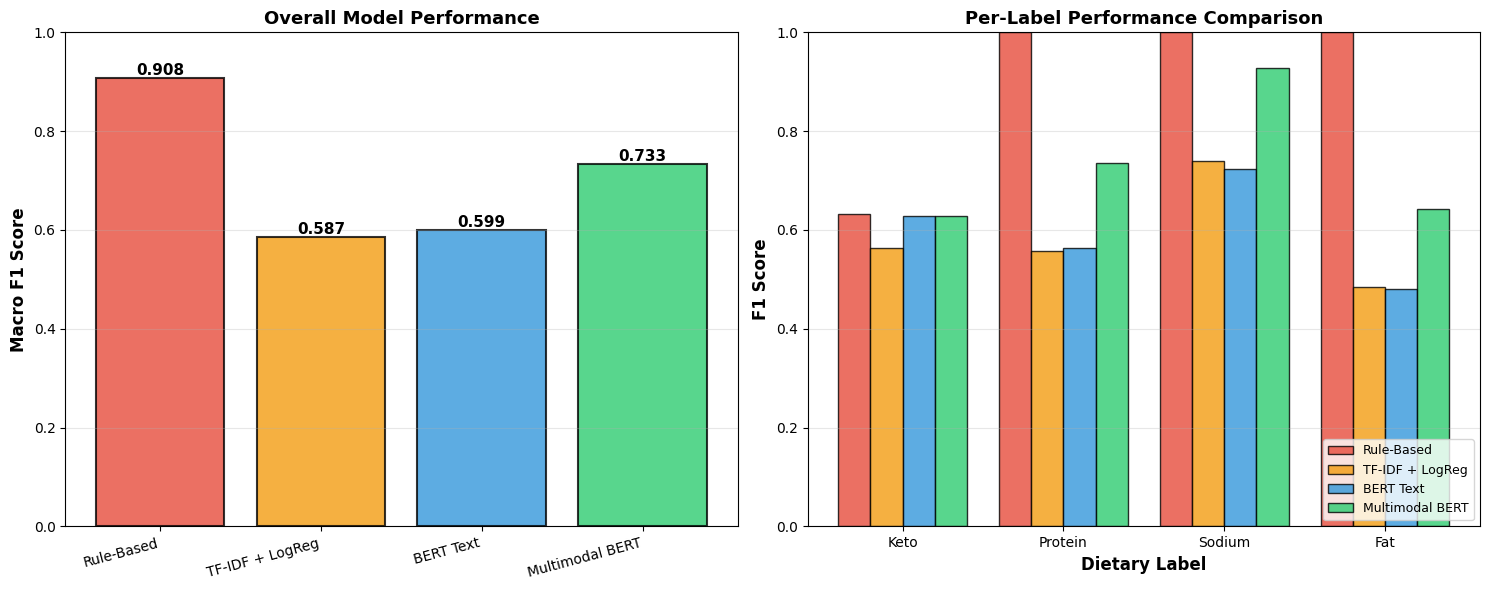

✓ Saved: model_comparison.png


In [15]:
# Create comparison visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Overall macro-F1 comparison
models = comparison_df['Model'].values
macro_f1s = comparison_df['Macro-F1'].values
colors = ['#e74c3c', '#f39c12', '#3498db', '#2ecc71']

bars = ax1.bar(range(len(models)), macro_f1s, color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)

# Add value labels
for bar, score in zip(bars, macro_f1s):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{score:.3f}',
            ha='center', va='bottom', fontweight='bold', fontsize=11)

ax1.set_xticks(range(len(models)))
ax1.set_xticklabels(models, rotation=15, ha='right')
ax1.set_ylabel('Macro F1 Score', fontsize=12, fontweight='bold')
ax1.set_title('Overall Model Performance', fontsize=13, fontweight='bold')
ax1.set_ylim(0, 1.0)
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Per-label F1 comparison
x = np.arange(len(LABELS))
width = 0.2

for i, model_name in enumerate(models):
    model_scores = [comparison_df.loc[comparison_df['Model'] == model_name, label].values[0]
                    for label in LABELS]
    ax2.bar(x + i*width, model_scores, width, label=model_name,
            color=colors[i], edgecolor='black', linewidth=1, alpha=0.8)

ax2.set_ylabel('F1 Score', fontsize=12, fontweight='bold')
ax2.set_xlabel('Dietary Label', fontsize=12, fontweight='bold')
ax2.set_title('Per-Label Performance Comparison', fontsize=13, fontweight='bold')
ax2.set_xticks(x + width * 1.5)
ax2.set_xticklabels(['Keto', 'Protein', 'Sodium', 'Fat'])
ax2.legend(fontsize=9, loc='lower right')
ax2.set_ylim(0, 1.0)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: model_comparison.png")

---
## 11. Error Analysis

Examine misclassifications to identify systematic failure patterns.

In [16]:
# Use best model for error analysis (multimodal BERT)
y_pred_best = y_pred_mm

# Find misclassified products for each label
print("Error Analysis:")
print("="*70)

error_examples = []

for i, label in enumerate(LABELS):
    # Find errors
    errors = (y_test[:, i] != y_pred_best[:, i])
    n_errors = errors.sum()

    print(f"\n{label.upper()}:")
    print(f"  Errors: {n_errors}/{len(y_test)} ({n_errors/len(y_test)*100:.1f}%)")

    if n_errors > 0:
        # Get indices of errors
        error_indices = np.where(errors)[0]

        # Show a few examples
        for idx in error_indices[:3]:  # Show first 3 errors
            test_idx = X_test_text.index[idx]
            product = df.loc[test_idx]

            true_label = y_test[idx, i]
            pred_label = y_pred_best[idx, i]

            # Get nutrition value
            if 'sodium' in label:
                value = product['sodium_per_serving']
                threshold = FDA_THRESHOLDS['low_sodium']
                unit = 'mg'
            elif 'fat' in label:
                value = product['fat_per_serving']
                threshold = FDA_THRESHOLDS['low_fat']
                unit = 'g'
            elif 'protein' in label:
                value = product['protein_per_serving']
                threshold = FDA_THRESHOLDS['high_protein']
                unit = 'g'
            else:  # keto
                value = product['net_carbs_per_serving']
                threshold = FDA_THRESHOLDS['keto_net_carbs']
                unit = 'g'

            print(f"\n  Example: {product['name'][:50]}")
            print(f"    Value: {value:.1f}{unit} (Threshold: {threshold}{unit})")
            print(f"    True: {true_label}, Predicted: {pred_label}")
            print(f"    Ingredients: {product[ingredients_col][:80]}...")

            error_examples.append({
                'label': label,
                'product': product['name'],
                'value': value,
                'threshold': threshold,
                'true': true_label,
                'pred': pred_label
            })

print("\n" + "="*70)

Error Analysis:

KETO_COMPLIANT:
  Errors: 13/56 (23.2%)

  Example: Pesto Rosso
    Value: 4.8g (Threshold: 40g)
    True: 1, Predicted: 0
    Ingredients: Tomato pulp 37%, sunflower oil, tomato concentrate 15%, Grana Padano PDO cheese ...

  Example: Kiri carré 8p
    Value: 0.6g (Threshold: 40g)
    True: 1, Predicted: 0
    Ingredients: fromage blanc, lait écrémé réhydraté, matière grasse laitière, protéines de lait...

  Example: Atún con tomate
    Value: 2.3g (Threshold: 40g)
    True: 1, Predicted: 0
    Ingredients: Thon 65 et sauce tomate 35 (eau, hui\e de soja, concentré de tomate, glucose, su...

HIGH_PROTEIN:
  Errors: 13/56 (23.2%)

  Example: Pesto Rosso
    Value: 1.9g (Threshold: 10g)
    True: 0, Predicted: 1
    Ingredients: Tomato pulp 37%, sunflower oil, tomato concentrate 15%, Grana Padano PDO cheese ...

  Example: Bol Bol Ketchup
    Value: 1.0g (Threshold: 10g)
    True: 0, Predicted: 1
    Ingredients: Eau, sucre, concentré de tomate, vinaigre de table, amidon

---
## 12. Save Results

Export predictions, metrics, and analysis for downstream use.

In [17]:
# Create results DataFrame with all predictions
results_df = df.loc[X_test_text.index].copy()

# Add predictions from all models
for model_name, predictions in results.items():
    model_suffix = model_name.lower().replace(' ', '_').replace('+', '')
    for i, label in enumerate(LABELS):
        results_df[f'{label}_pred_{model_suffix}'] = predictions[:, i]

# Add true labels
for i, label in enumerate(LABELS):
    results_df[f'{label}_true'] = y_test[:, i]

# Save
results_df.to_csv('task1_results.csv', index=False)
print(f"✓ Saved: task1_results.csv ({len(results_df)} products)")

# Save metrics
comparison_df.to_csv('task1_metrics.csv', index=False)
print("✓ Saved: task1_metrics.csv")

# Save error analysis
with open('error_analysis.txt', 'w') as f:
    f.write("TASK 1: ERROR ANALYSIS\n")
    f.write("="*70 + "\n\n")

    for example in error_examples[:20]:  # Save top 20 examples
        f.write(f"Label: {example['label']}\n")
        f.write(f"Product: {example['product']}\n")
        f.write(f"Value: {example['value']:.1f} (Threshold: {example['threshold']})\n")
        f.write(f"True: {example['true']}, Predicted: {example['pred']}\n")
        f.write("-"*70 + "\n\n")

print("✓ Saved: error_analysis.txt")

✓ Saved: task1_results.csv (56 products)
✓ Saved: task1_metrics.csv
✓ Saved: error_analysis.txt


---
## 13. Summary

Final performance summary and conclusions.

In [18]:
print("="*70)
print("TASK 1: DIETARY CLASSIFICATION - FINAL SUMMARY")
print("="*70)

print("\n📊 Dataset:")
print(f"  Total products: {len(df)}")
print(f"  Training set: {len(X_train_text)} ({len(X_train_text)/len(df)*100:.1f}%)")
print(f"  Test set: {len(X_test_text)} ({len(X_test_text)/len(df)*100:.1f}%)")

print("\n🏷️  Labels:")
for label in LABELS:
    count = df[label].sum()
    pct = (count / len(df)) * 100
    print(f"  {label:20s}: {count:4d} ({pct:5.1f}%)")

print("\n🤖 Models:")
for _, row in comparison_df.iterrows():
    print(f"  {row['Model']:20s}: Macro-F1 = {row['Macro-F1']:.3f}")

print(f"\n✓ Best Model: {best_model}")
print(f"  Performance: Macro-F1 = {best_score:.3f}")

print("\n📈 Inter-Annotator Agreement:")
print(f"  Cohen's κ = {overall_kappa:.3f}")
if overall_kappa > 0.80:
    print("  Quality: Excellent (near-perfect agreement)")
elif overall_kappa > 0.60:
    print("  Quality: Good (substantial agreement)")

print("\n📁 Output Files:")
print("  - task1_results.csv (detailed predictions)")
print("  - task1_metrics.csv (performance metrics)")
print("  - model_comparison.png (visualization)")
print("  - error_analysis.txt (error examples)")

print("\n" + "="*70)
print("✓ Task 1 Complete!")
print("="*70)

TASK 1: DIETARY CLASSIFICATION - FINAL SUMMARY

📊 Dataset:
  Total products: 279
  Training set: 223 (79.9%)
  Test set: 56 (20.1%)

🏷️  Labels:
  keto_compliant      :   90 ( 32.3%)
  high_protein        :  105 ( 37.6%)
  low_sodium          :  124 ( 44.4%)
  low_fat             :  103 ( 36.9%)

🤖 Models:
  Rule-Based          : Macro-F1 = 0.908
  TF-IDF + LogReg     : Macro-F1 = 0.587
  BERT Text           : Macro-F1 = 0.599
  Multimodal BERT     : Macro-F1 = 0.733

✓ Best Model: Rule-Based
  Performance: Macro-F1 = 0.908

📈 Inter-Annotator Agreement:
  Cohen's κ = 0.884
  Quality: Excellent (near-perfect agreement)

📁 Output Files:
  - task1_results.csv (detailed predictions)
  - task1_metrics.csv (performance metrics)
  - model_comparison.png (visualization)
  - error_analysis.txt (error examples)

✓ Task 1 Complete!


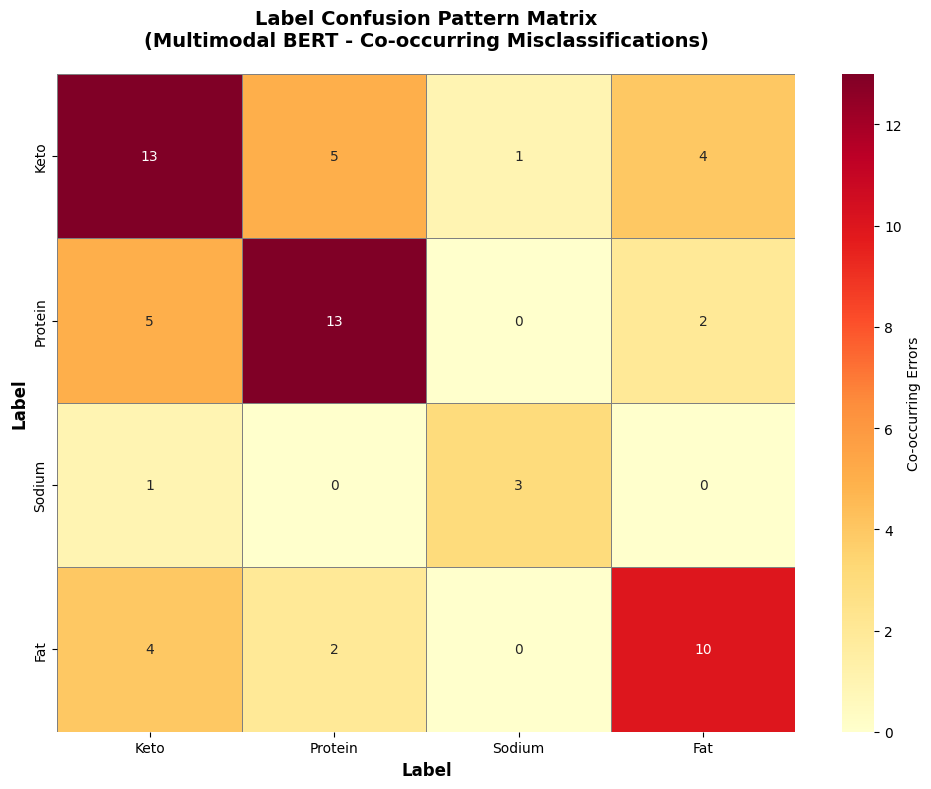

✓ Saved: confusion_patterns.png

Interpretation: Diagonal shows single-label errors.
Off-diagonal shows labels that are frequently mispredicted together.


In [19]:
# Advanced Analysis 1: Confusion Pattern Heatmap
# Shows which label combinations are frequently misclassified together

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate confusion patterns for best model (multimodal)
confusion_patterns = np.zeros((4, 4))

for i in range(len(y_test)):
    true_labels = y_test[i]
    pred_labels = y_pred_mm[i]

    # Find mismatches
    errors = (true_labels != pred_labels)
    error_indices = np.where(errors)[0]

    # Count co-occurring errors
    for idx1 in error_indices:
        for idx2 in error_indices:
            confusion_patterns[idx1, idx2] += 1

# Create heatmap
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(confusion_patterns, annot=True, fmt='.0f', cmap='YlOrRd',
            xticklabels=['Keto', 'Protein', 'Sodium', 'Fat'],
            yticklabels=['Keto', 'Protein', 'Sodium', 'Fat'],
            cbar_kws={'label': 'Co-occurring Errors'},
            linewidths=0.5, linecolor='gray')

ax.set_title('Label Confusion Pattern Matrix\n(Multimodal BERT - Co-occurring Misclassifications)',
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Label', fontsize=12, fontweight='bold')
ax.set_ylabel('Label', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('confusion_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: confusion_patterns.png")
print("\nInterpretation: Diagonal shows single-label errors.")
print("Off-diagonal shows labels that are frequently mispredicted together.")

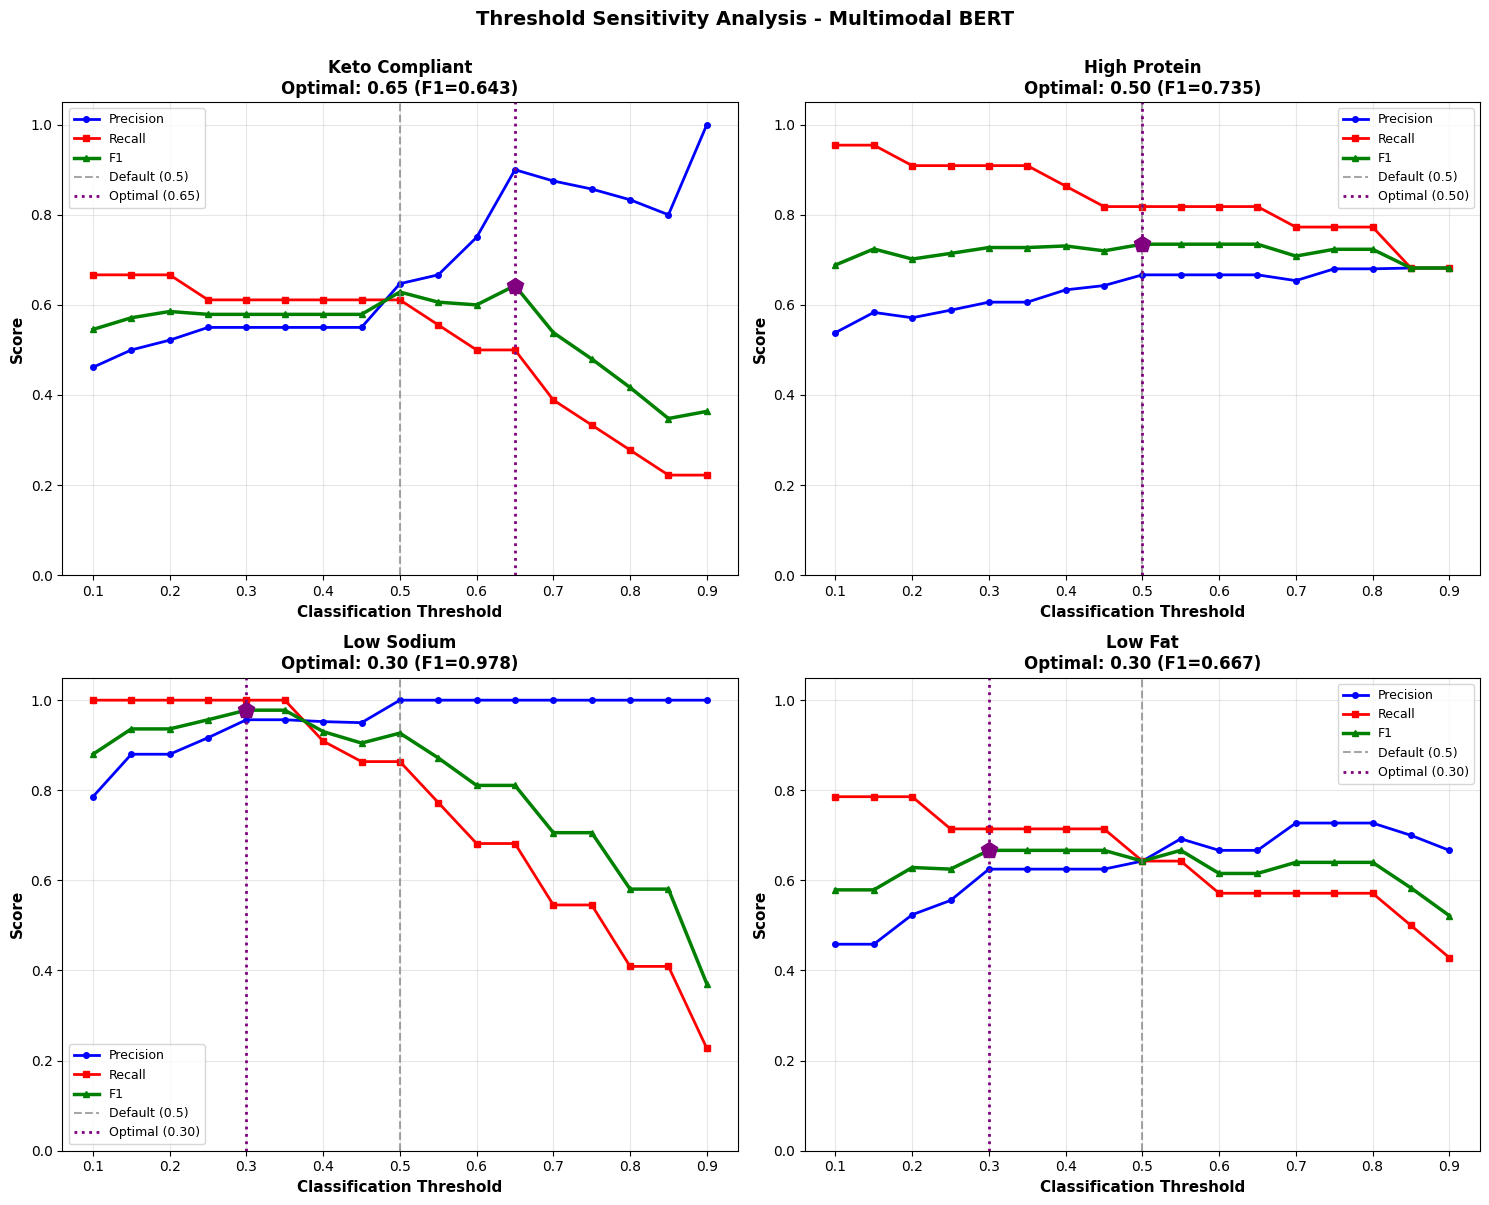

✓ Saved: threshold_sensitivity.png

Optimal thresholds:
  keto_compliant      : 0.65
  high_protein        : 0.50
  low_sodium          : 0.30
  low_fat             : 0.30


In [20]:
# Advanced Analysis 2: Threshold Sensitivity Analysis
# Shows optimal threshold for each label

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Get probability outputs from multimodal model
model_mm.eval()
all_probs = []

with torch.no_grad():
    for batch in test_mm_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        numeric_features = batch['numeric_features'].to(device)

        outputs = model_mm(input_ids, attention_mask, numeric_features)
        probs = torch.sigmoid(outputs).cpu().numpy()
        all_probs.extend(probs)

all_probs = np.array(all_probs)

# Test different thresholds
thresholds = np.arange(0.1, 0.95, 0.05)
results = {label: {'thresholds': [], 'precision': [], 'recall': [], 'f1': []}
           for label in LABELS}

for threshold in thresholds:
    predictions = (all_probs > threshold).astype(int)

    for i, label in enumerate(LABELS):
        p = precision_score(y_test[:, i], predictions[:, i], zero_division=0)
        r = recall_score(y_test[:, i], predictions[:, i], zero_division=0)
        f1 = f1_score(y_test[:, i], predictions[:, i], zero_division=0)

        results[label]['thresholds'].append(threshold)
        results[label]['precision'].append(p)
        results[label]['recall'].append(r)
        results[label]['f1'].append(f1)

# Plot
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, label in enumerate(LABELS):
    ax = axes[i]

    ax.plot(results[label]['thresholds'], results[label]['precision'],
            'b-o', label='Precision', linewidth=2, markersize=4)
    ax.plot(results[label]['thresholds'], results[label]['recall'],
            'r-s', label='Recall', linewidth=2, markersize=4)
    ax.plot(results[label]['thresholds'], results[label]['f1'],
            'g-^', label='F1', linewidth=2.5, markersize=5)

    # Mark 0.5 threshold
    ax.axvline(x=0.5, color='gray', linestyle='--', linewidth=1.5, alpha=0.7, label='Default (0.5)')

    # Find optimal F1 threshold
    optimal_idx = np.argmax(results[label]['f1'])
    optimal_threshold = results[label]['thresholds'][optimal_idx]
    optimal_f1 = results[label]['f1'][optimal_idx]

    ax.axvline(x=optimal_threshold, color='purple', linestyle=':', linewidth=2,
               label=f'Optimal ({optimal_threshold:.2f})')
    ax.plot(optimal_threshold, optimal_f1, 'p', color='purple', markersize=12)

    ax.set_xlabel('Classification Threshold', fontsize=11, fontweight='bold')
    ax.set_ylabel('Score', fontsize=11, fontweight='bold')
    ax.set_title(f'{label.replace("_", " ").title()}\nOptimal: {optimal_threshold:.2f} (F1={optimal_f1:.3f})',
                 fontsize=12, fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.grid(alpha=0.3)
    ax.set_ylim(0, 1.05)

plt.suptitle('Threshold Sensitivity Analysis - Multimodal BERT',
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('threshold_sensitivity.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: threshold_sensitivity.png")
print("\nOptimal thresholds:")
for label in LABELS:
    optimal_idx = np.argmax(results[label]['f1'])
    print(f"  {label:20s}: {results[label]['thresholds'][optimal_idx]:.2f}")

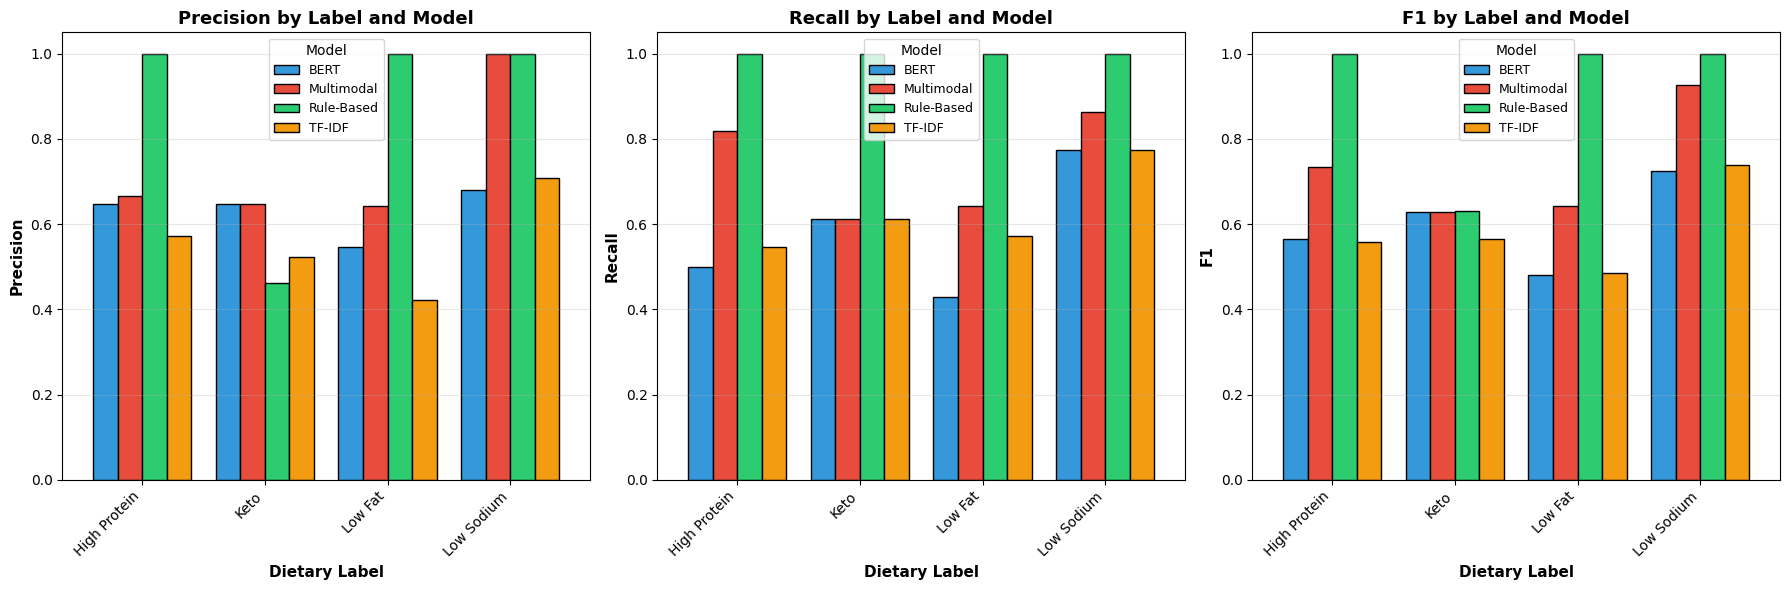

✓ Saved: per_label_breakdown.png

Detailed Performance Table:
Model             BERT  Multimodal  Rule-Based    TF-IDF
Label                                                   
High Protein  0.564103    0.734694    1.000000  0.558140
Keto          0.628571    0.628571    0.631579  0.564103
Low Fat       0.480000    0.642857    1.000000  0.484848
Low Sodium    0.723404    0.926829    1.000000  0.739130


In [21]:
# Advanced Analysis 3: Detailed Per-Label Performance Breakdown

from sklearn.metrics import precision_recall_fscore_support, classification_report

# Create comprehensive per-label comparison
label_names = ['Keto', 'High Protein', 'Low Sodium', 'Low Fat']
models = {
    'Rule-Based': y_pred_rules,
    'TF-IDF': y_pred_tfidf,
    'BERT': y_pred_bert,
    'Multimodal': y_pred_mm
}

# Collect detailed metrics
detailed_results = []

for model_name, predictions in models.items():
    for i, label in enumerate(LABELS):
        p, r, f1, support = precision_recall_fscore_support(
            y_test[:, i], predictions[:, i], average='binary', zero_division=0
        )

        detailed_results.append({
            'Model': model_name,
            'Label': label_names[i],
            'Precision': p,
            'Recall': r,
            'F1': f1,
            'Support': support
        })

results_df = pd.DataFrame(detailed_results)

# Create grouped bar chart
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

metrics = ['Precision', 'Recall', 'F1']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for idx, metric in enumerate(metrics):
    ax = axes[idx]

    # Prepare data
    pivot_data = results_df.pivot(index='Label', columns='Model', values=metric)

    # Plot
    pivot_data.plot(kind='bar', ax=ax, color=colors, width=0.8, edgecolor='black', linewidth=1)

    ax.set_title(f'{metric} by Label and Model', fontsize=13, fontweight='bold')
    ax.set_xlabel('Dietary Label', fontsize=11, fontweight='bold')
    ax.set_ylabel(metric, fontsize=11, fontweight='bold')
    ax.set_ylim(0, 1.05)
    ax.legend(title='Model', fontsize=9, title_fontsize=10)
    ax.grid(axis='y', alpha=0.3)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('per_label_breakdown.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: per_label_breakdown.png")

# Print summary table
print("\nDetailed Performance Table:")
print("="*80)
summary_pivot = results_df.pivot_table(
    index='Label',
    columns='Model',
    values='F1',
    aggfunc='first'
)
print(summary_pivot.to_string())
print("="*80)

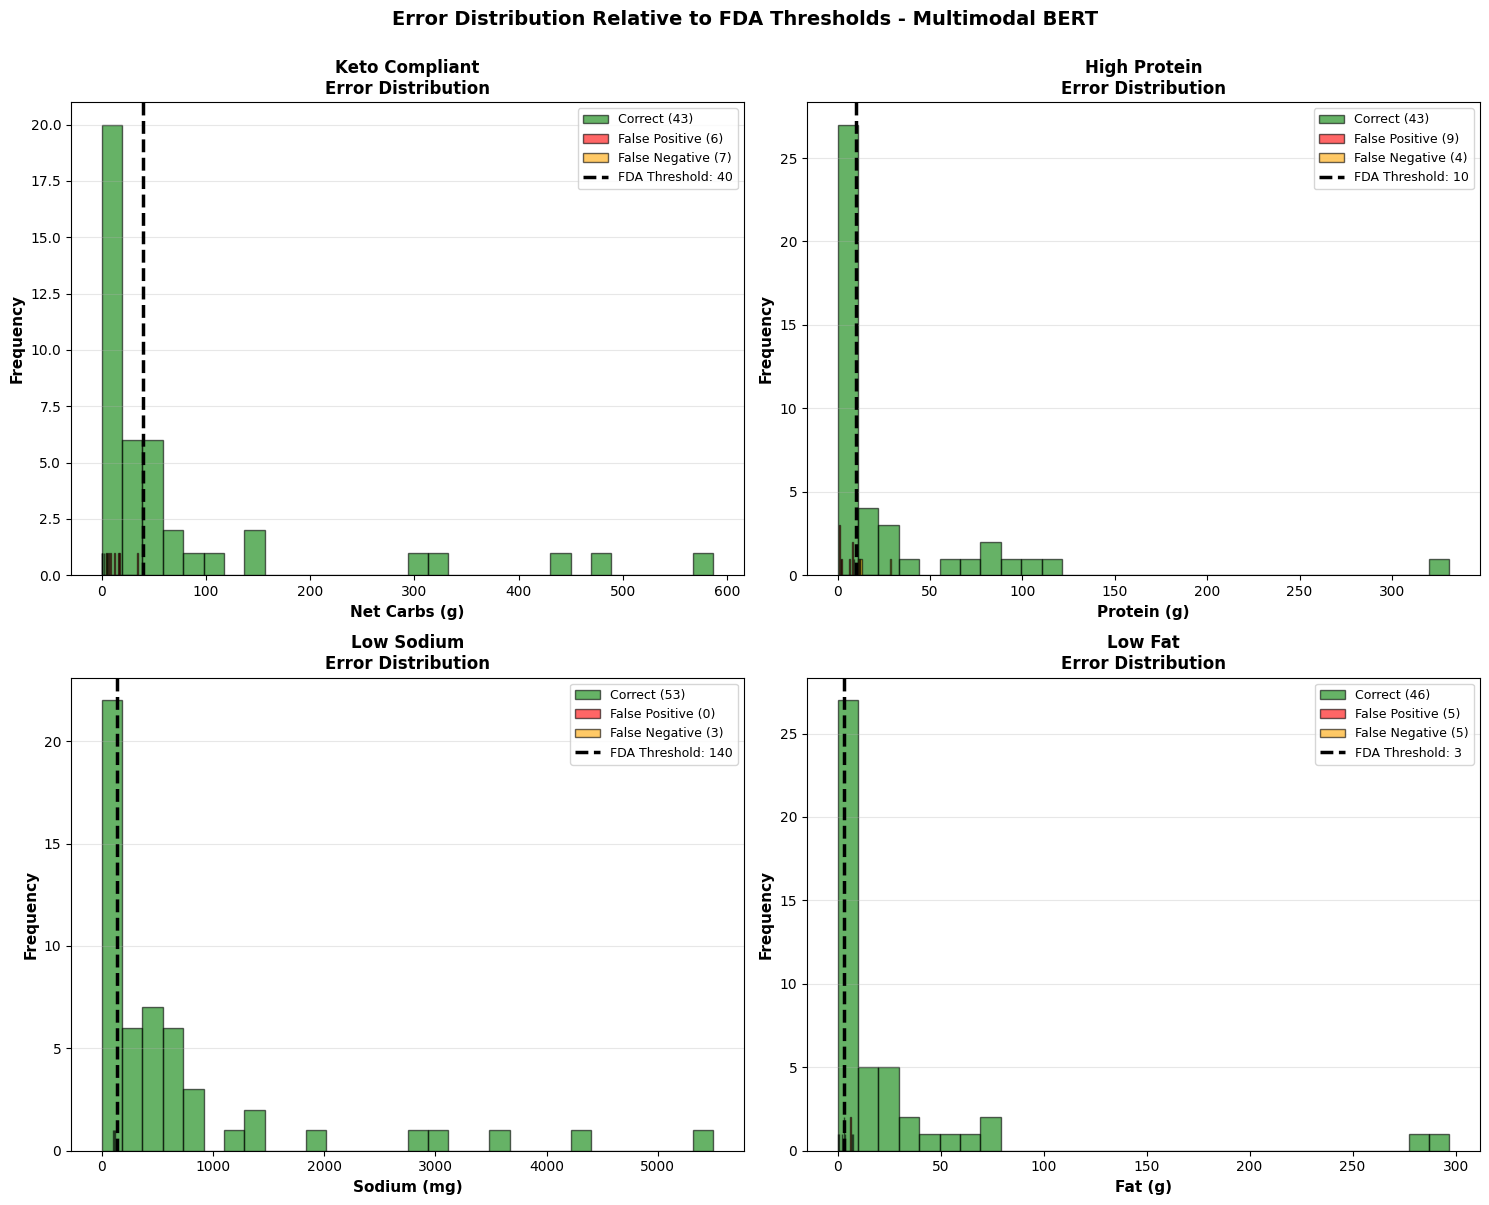

✓ Saved: error_distribution.png

Interpretation: Shows whether errors occur near thresholds (borderline cases)
or far from thresholds (systematic model failures).


In [22]:
# Advanced Analysis 4: Error Distribution by Nutrition Value

import matplotlib.pyplot as plt
import numpy as np

# Analyze where errors occur relative to FDA thresholds
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

# Get test indices
test_indices = X_test_text.index

# Nutrition columns and thresholds
nutrition_analysis = [
    ('net_carbs_per_serving', 'keto_compliant', 0, FDA_THRESHOLDS['keto_net_carbs'], 'Net Carbs (g)'),
    ('protein_per_serving', 'high_protein', 1, FDA_THRESHOLDS['high_protein'], 'Protein (g)'),
    ('sodium_per_serving', 'low_sodium', 2, FDA_THRESHOLDS['low_sodium'], 'Sodium (mg)'),
    ('fat_per_serving', 'low_fat', 3, FDA_THRESHOLDS['low_fat'], 'Fat (g)')
]

for idx, (col, label, label_idx, threshold, xlabel) in enumerate(nutrition_analysis):
    ax = axes[idx]

    # Get nutrition values for test set
    nutrition_values = df.loc[test_indices, col].values

    # Classify errors
    true_labels = y_test[:, label_idx]
    pred_labels = y_pred_mm[:, label_idx]

    correct = (true_labels == pred_labels)
    false_positive = (true_labels == 0) & (pred_labels == 1)
    false_negative = (true_labels == 1) & (pred_labels == 0)

    # Plot histograms
    bins = 30
    alpha = 0.6

    ax.hist(nutrition_values[correct], bins=bins, alpha=alpha,
            color='green', label=f'Correct ({correct.sum()})', edgecolor='black')
    ax.hist(nutrition_values[false_positive], bins=bins, alpha=alpha,
            color='red', label=f'False Positive ({false_positive.sum()})', edgecolor='black')
    ax.hist(nutrition_values[false_negative], bins=bins, alpha=alpha,
            color='orange', label=f'False Negative ({false_negative.sum()})', edgecolor='black')

    # Add threshold line
    ax.axvline(threshold, color='black', linestyle='--', linewidth=2.5,
               label=f'FDA Threshold: {threshold}')

    ax.set_xlabel(xlabel, fontsize=11, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax.set_title(f'{label.replace("_", " ").title()}\nError Distribution',
                 fontsize=12, fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Error Distribution Relative to FDA Thresholds - Multimodal BERT',
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('error_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: error_distribution.png")
print("\nInterpretation: Shows whether errors occur near thresholds (borderline cases)")
print("or far from thresholds (systematic model failures).")